dataset: https://www.kaggle.com/fedesoriano/heart-failure-prediction

1. Load heart disease dataset in pandas dataframe.
2. Remove outliers using Z score. Usual guideline is to remove anything that has Z score > 3 formula or Z score < -3.
3. Convert text columns to numbers using label encoding and one hot encoding.
4. Apply scaling.
5. Build a classification model using support vector machine. Use standalone model as well as Bagging model and check if you see any difference in the performance.
6. Now use decision tree classifier. Use standalone model as well as Bagging and check if you notice any difference in performance
7. Comparing performance of svm and decision tree classifier figure out where it makes most sense to use bagging and why. Use internet to figure out in what conditions bagging works the best.

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA

In [44]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Data Analysis & Preprocessing

In [45]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [46]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [47]:
df.select_dtypes(include=[np.number]).groupby('HeartDisease').mean()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
HeartDisease,,,,,,
0,50.551220,130.180488,227.121951,0.107317,148.151220,0.408049
1,55.899606,134.185039,175.940945,0.334646,127.655512,1.274213


<Axes: xlabel='Sex'>

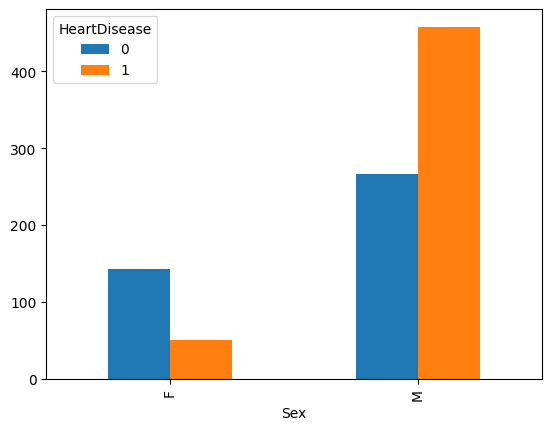

In [48]:
pd.crosstab(df.Sex, df.HeartDisease).plot(kind='bar')

<Axes: xlabel='ChestPainType'>

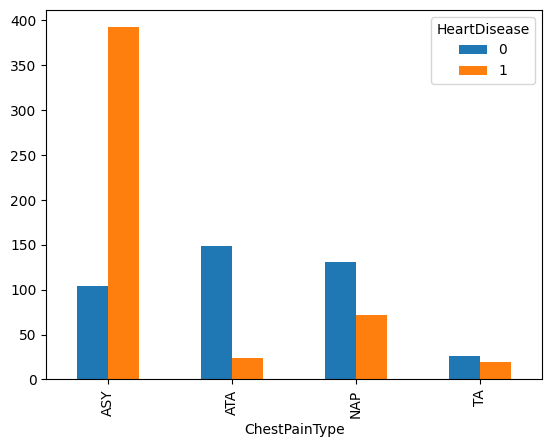

In [49]:
pd.crosstab(df.ChestPainType, df.HeartDisease).plot(kind='bar')

<Axes: xlabel='RestingECG'>

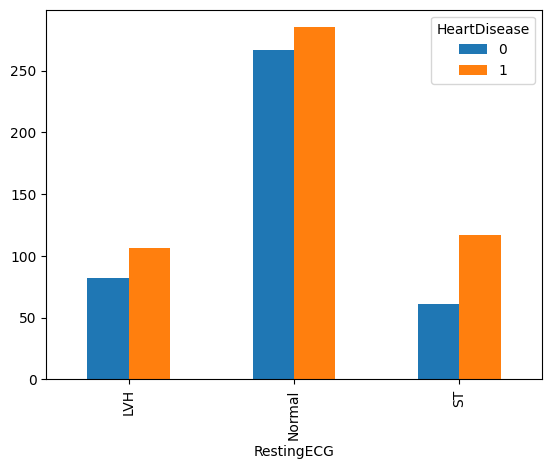

In [50]:
pd.crosstab(df.RestingECG, df.HeartDisease).plot(kind='bar')

<Axes: xlabel='ExerciseAngina'>

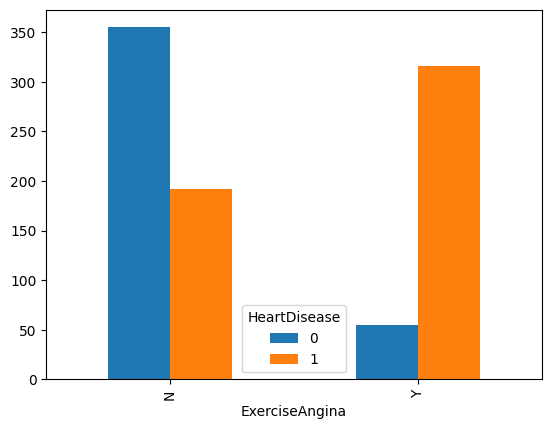

In [51]:
pd.crosstab(df.ExerciseAngina, df.HeartDisease).plot(kind='bar')

<Axes: xlabel='ST_Slope'>

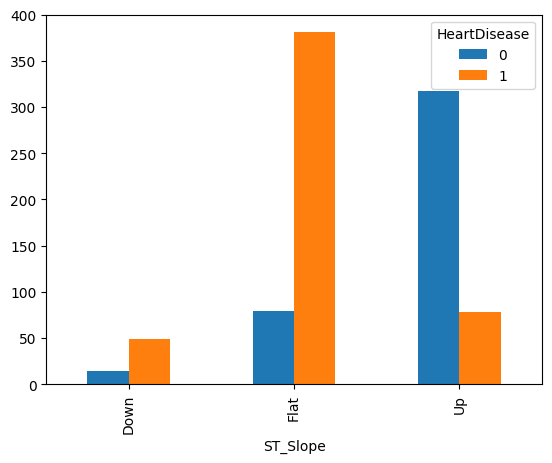

In [52]:
pd.crosstab(df.ST_Slope, df.HeartDisease).plot(kind='bar')

In [53]:
print(df.Sex.unique())
print(df.ChestPainType.unique())
print(df.RestingECG.unique())
print(df.ExerciseAngina.unique())
print(df.ST_Slope.unique())

['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']


In [54]:
df.HeartDisease.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

### Treating Outliers

In [55]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [56]:
df[df.Cholesterol > (df.Cholesterol.mean() + 3 * df.Cholesterol.std())]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0


In [57]:
df = df[df.Cholesterol <= (df.Cholesterol.mean() + 3 * df.Cholesterol.std())]
df.shape

(915, 12)

In [58]:
df[df.MaxHR > (df.MaxHR.mean() + 3 * df.MaxHR.std())]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [59]:
df[df.FastingBS > (df.FastingBS.mean() + 3 * df.FastingBS.std())]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [60]:
df[df.Oldpeak > (df.Oldpeak.mean() + 3 * df.Oldpeak.std())]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
166,50,M,ASY,140,231,0,ST,140,Y,5.0,Flat,1
702,59,M,TA,178,270,0,LVH,145,N,4.2,Down,0
771,55,M,ASY,140,217,0,Normal,111,Y,5.6,Down,1
791,51,M,ASY,140,298,0,Normal,122,Y,4.2,Flat,1
850,62,F,ASY,160,164,0,LVH,145,N,6.2,Down,1
900,58,M,ASY,114,318,0,ST,140,N,4.4,Down,1


In [61]:
df = df[df.Oldpeak <= (df.Oldpeak.mean() + 3 * df.Oldpeak.std())]
df.shape

(909, 12)

In [62]:
df[df.RestingBP > (df.RestingBP.mean() + 3 * df.RestingBP.std())]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
109,39,M,ATA,190,241,0,Normal,106,N,0.0,Up,0
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1
365,64,F,ASY,200,0,0,Normal,140,Y,1.0,Flat,1
399,61,M,NAP,200,0,1,ST,70,N,0.0,Flat,1
592,61,M,ASY,190,287,1,LVH,150,Y,2.0,Down,1
732,56,F,ASY,200,288,1,LVH,133,Y,4.0,Down,1
759,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1


In [63]:
df = df[df.RestingBP <= (df.RestingBP.mean() + 3 * df.RestingBP.std())]
df.shape

(902, 12)

### Encoding

In [64]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


label encoding

In [65]:
le = LabelEncoder()

df['Sex'] = le.fit_transform(df['Sex'])
df['ExerciseAngina'] = le.fit_transform(df['ExerciseAngina'])

df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144,193,1,Normal,141,0,3.4,Flat,1
915,57,1,ASY,130,131,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130,236,0,LVH,174,0,0.0,Flat,1


ordinal encoding

In [66]:
oe = OrdinalEncoder(categories = [["Up", "Flat", "Down"]], dtype=int)

df["ST_Slope"] = oe.fit_transform(df[["ST_Slope"]])
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,0,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,1,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,0,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,1,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264,0,Normal,132,0,1.2,1,1
914,68,1,ASY,144,193,1,Normal,141,0,3.4,1,1
915,57,1,ASY,130,131,0,Normal,115,1,1.2,1,1
916,57,0,ATA,130,236,0,LVH,174,0,0.0,1,1


one hot encoding

In [67]:
df_ohe = df[['ChestPainType', 'RestingECG']]
df_ohe

,ChestPainType,RestingECG
0,ATA,Normal
1,NAP,Normal
2,ATA,ST
3,ASY,Normal
4,NAP,Normal
...,...,...
913,TA,Normal
914,ASY,Normal
915,ASY,Normal
916,ATA,LVH


In [68]:
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_ohe = df_ohe.astype(float)
df_ohe

,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...
913,0.0,0.0,1.0,1.0,0.0
914,0.0,0.0,0.0,1.0,0.0
915,0.0,0.0,0.0,1.0,0.0
916,1.0,0.0,0.0,0.0,0.0


In [69]:
df = pd.concat([df, df_ohe], axis=1)
df.drop(columns=['ChestPainType', 'RestingECG'], inplace=True)
df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,0,0,1.0,0.0,0.0,1.0,0.0
1,49,0,160,180,0,156,0,1.0,1,1,0.0,1.0,0.0,1.0,0.0
2,37,1,130,283,0,98,0,0.0,0,0,1.0,0.0,0.0,0.0,1.0
3,48,0,138,214,0,108,1,1.5,1,1,0.0,0.0,0.0,1.0,0.0
4,54,1,150,195,0,122,0,0.0,0,0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,110,264,0,132,0,1.2,1,1,0.0,0.0,1.0,1.0,0.0
914,68,1,144,193,1,141,0,3.4,1,1,0.0,0.0,0.0,1.0,0.0
915,57,1,130,131,0,115,1,1.2,1,1,0.0,0.0,0.0,1.0,0.0
916,57,0,130,236,0,174,0,0.0,1,1,1.0,0.0,0.0,0.0,0.0


### Scaling

In [70]:
X = df.drop(columns='HeartDisease')
y = df.HeartDisease

In [71]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)
X_scaled

array([[-1.42896269,  0.51485643,  0.46089071, ..., -0.22914788,
         0.80934904, -0.49062742],
       [-0.47545956, -1.94228905,  1.5925728 , ..., -0.22914788,
         0.80934904, -0.49062742],
       [-1.74679706,  0.51485643, -0.10495034, ..., -0.22914788,
        -1.23556086,  2.03820649],
       ...,
       [ 0.37209878,  0.51485643, -0.10495034, ..., -0.22914788,
         0.80934904, -0.49062742],
       [ 0.37209878, -1.94228905, -0.10495034, ..., -0.22914788,
        -1.23556086, -0.49062742],
       [-1.64085227,  0.51485643,  0.3477225 , ..., -0.22914788,
         0.80934904, -0.49062742]])

## Model

In [90]:
model_params = {
    'svm': {
        'model': SVC(),
        'params' : {}  
    },
    'random_forest': {
        'model': RandomForestClassifier(n_estimators=80),
        'params' : {}
    },
    'logistic_regression' : {
        'model': LogisticRegression(max_iter=10000),
        'params': {}
    },
    'decision_tree' : {
        'model': DecisionTreeClassifier(),
        'params': {}
    },
    'knn' : {
        'model': KNeighborsClassifier(n_neighbors=8),
        'params': {}
    },
}

In [91]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_scaled, y)
    
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_results = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df_results

,model,best_score,best_params
0,svm,0.813671,{}
1,random_forest,0.823671,{}
2,logistic_regression,0.800393,{}
3,decision_tree,0.730460,{}
4,knn,0.811492,{}


### Bagging

In [85]:
bag_model = BaggingClassifier(
    estimator = DecisionTreeClassifier(),
    n_estimators = 100,
    max_samples = 0.8,
    oob_score = True,
    random_state = 0
)

scores = cross_val_score(bag_model, X_scaled, y, cv=5)
scores.mean()

0.8036955187231429

In [86]:
bag_model = BaggingClassifier(
    estimator = SVC(),
    n_estimators = 100,
    max_samples = 0.8,
    oob_score = True,
    random_state = 0
)

scores = cross_val_score(bag_model, X_scaled, y, cv=5)
scores.mean()

0.8170104358502147

* Using bagging in case of **SVM** doesn't make much difference in terms of model accuracy. 
* Bagging is effective when we have *high variance* and *instable model* such as **decision tree**.

In [87]:
bag_model = BaggingClassifier(
    estimator = RandomForestClassifier(),
    n_estimators = 100,
    max_samples = 0.8,
    oob_score = True,
    random_state = 0
)

scores = cross_val_score(bag_model, X_scaled, y, cv=5)
scores.mean()

0.8358686310620012

### PCA

In [98]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(902, 10)

In [99]:
bag_model = BaggingClassifier(
    estimator = RandomForestClassifier(),
    n_estimators = 100,
    max_samples = 0.8,
    oob_score = True,
    random_state = 0
)

scores = cross_val_score(bag_model, X_pca, y, cv=5)
scores.mean()

0.8380417434008594